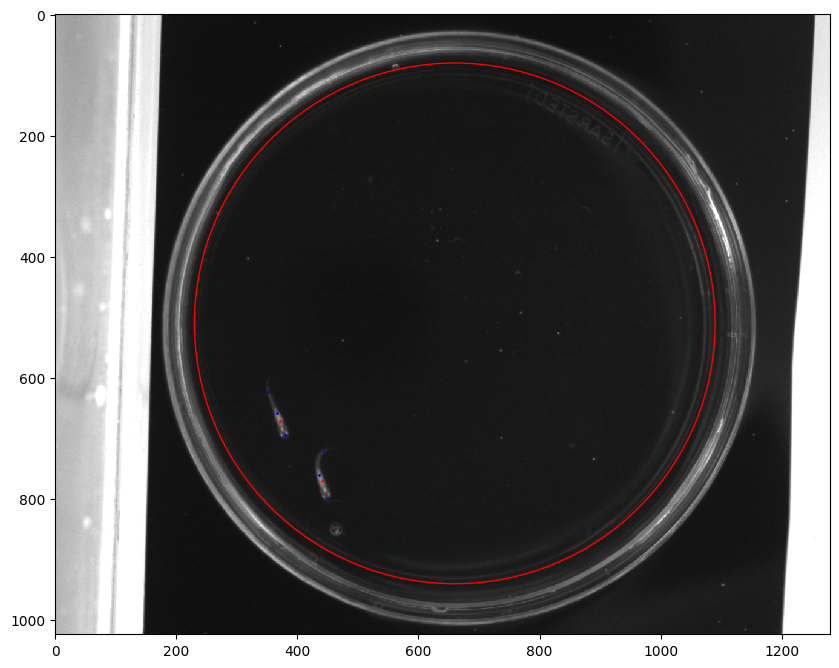

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
pos=np.load('data_npy/2.npy')
vid=np.load('data_video/2.npy')
midline=np.load('data_midline/2_consistent.npy')
DATA_circle=np.load('data_circle/2.npy')
#3584*3400
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(pos[0,:,0], pos[0,:,1], 'o', color='red', markersize=1)
ax.plot(midline[0,:,0,0], midline[0,:,0,1], 'o', color='blue', markersize=1)
ax.plot(midline[0,:,1,0], midline[0,:,1,1], 'o', color='blue', markersize=1)
ax.plot(midline[0,:,2,0], midline[0,:,2,1], 'o', color='blue', markersize=1)
x,y,r=DATA_circle
circle=plt.Circle((x, y), r, color='r',fill=False)
ax.add_patch(circle)
ax.imshow(vid, interpolation='nearest')

In [3]:
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]
def angle_between_2vec(vec1, vec2, axis=2):
    """Calculate the angle between two vectors."""
    return np.arctan2(
        np.cross(vec1, vec2, axis=axis),
        np.sum(vec1 * vec2, axis=axis)
    )
position=midline[:,:,1,:]-DATA_circle[None,None,:2]
global_head_phi=angle_between_2vec(head,-position, axis=2)
theta=angle_between_2vec(-head, tail, axis=2)
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
R=300
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
Observed_head_phi=angle_between_2vec(Observed_vector,head[:,None,:,:], axis=3)
Observed_index=Observed_distance<=R

In [4]:
Radius=r-np.linalg.norm(position, axis=2)
Time=pos.shape[0]
print(Radius.shape)
Radius[Radius>R]=-1

(19365, 2)


In [5]:
angular_speed= angle_between_2vec(head[:-1,:,:],head[1:,:,:], axis=2)
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
speed=np.linalg.norm(velocity, axis=2)
velocity_phi=angle_between_2vec(head[:-1,:,:],velocity,axis=2)
v_para=speed*np.cos(velocity_phi)
v_norm=speed*np.sin(velocity_phi)
L1_dot=L1[1:]-L1[:-1]
L2_dot=L2[1:]-L2[:-1]
theta_dot=theta[1:]-theta[:-1]

In [6]:
import torch.nn as nn
import torch
grid=64
scale=(grid//2)/R
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self,in_channels=grid,num_channel=4, num_classes=6):
        super(ResNet18, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(num_channel, in_channels, kernel_size=4, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, in_channels, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 2*in_channels, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 4*in_channels, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 8*in_channels, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(8*in_channels, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
torch.manual_seed(0)

In [7]:
model = ResNet18(num_channel=4).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

CNN

TODO FIX INPUT2 as L1 should also (2,3) shape

In [12]:
INPUT1=np.stack([global_head_phi[:-1],Radius[:-1]],axis=2)
INPUT2=np.stack([np.tile(L1[:-1,None],(1,2,1)),np.tile(L2[:-1,None],(1,2,1)),np.tile(theta[:-1,None],(1,2,1)),Observed_distance[:-1],Observed_phi[:-1],Observed_index[:-1],Observed_head_phi[:-1]],axis=3)
OUTPUT=np.stack([L1_dot,L2_dot,theta_dot,v_para,v_norm,angular_speed],axis=2)
INPUT1=INPUT1.reshape(-1,2)
INPUT2=INPUT2.reshape(-1,2,7)
OUTPUT=OUTPUT.reshape(-1,6)

In [17]:
print(INPUT1.shape)
print(INPUT2.shape)
print(OUTPUT.shape)
batch_size=64
DATA_SIZE=INPUT1.shape[0]

(38728, 2)
(38728, 2, 7)
(38728, 6)


In [9]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'code'))
from local_param import DiscreteImage


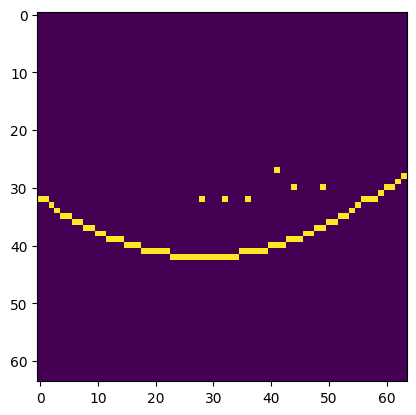

In [14]:
i=0
image=DiscreteImage(INPUT2[i,:,0],INPUT2[i,:,1],INPUT2[i,:,2],INPUT1[i,0],INPUT1[i,1],INPUT2[i,:,3],INPUT2[i,:,4],INPUT2[i,:,5].astype(bool),INPUT2[i,:,6])
plt.imshow(image.sum(axis=0))

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars
NUM_EPOCH=20
NUM_BATCH=DATA_SIZE//batch_size
np.random.seed(0)
def train_model(model, epochs=NUM_EPOCH, device='cuda'):
    best_test_loss = float('inf')
    # Set device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(device)
    model = model.to(device)
    # Loss function and optimizer
    # Training loop
    train_losses=[]
    test_losses=[]
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_loop = tqdm(range(NUM_BATCH), desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for _ in train_loop:
            train_loop.update(1)
            rand_index=np.random.randint(low=0,high=DATA_SIZE-1,size=batch_size)
            input1=INPUT1[rand_index]
            input2=INPUT2[rand_index]
            labels=OUTPUT[rand_index]
            input_data=np.zeros((batch_size,4,grid,grid))
            for i in range(batch_size):
                input_data[i] = DiscreteImage(input2[i,:,0],input2[i,:,1],input2[i,:,2],input1[i,0],input1[i,1],input2[i,:,3],input2[i,:,4],input2[i,:,5].astype(bool),input2[i,:,6])
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(torch.from_numpy(input_data).float().to(device))
            loss = criterion(outputs,torch.from_numpy(labels).float().to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            # Update progress bar
            train_loop.set_postfix(loss=loss.item())
        
        # Calculate training metrics
        train_loss /=(NUM_BATCH)
        print(f'Epoch {epoch+1}/{epochs} [Train] Loss: {train_loss:.4f}')
        train_losses.append(train_loss )
        """
        # Evaluation phase
        model.eval()  # Set model to evaluation mode
        
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            test_loop = tqdm(test_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Test]')
            for _ in range(NUM_BATCH):
                rand_index=np.random.randint(low=0,high=DATA_SIZE-1,size=batch_size)
                input1=INPUT1[rand_index]
                input2=INPUT2[rand_index]
                labels=OUTPUT[rand_index]
                input_data=np.zeros((batch_size,4,grid,grid))
                for i in range(batch_size):
                    input_data[i] = DiscreteImage(*input1[i], *input2[i])
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                test_loss += loss.item()
                test_loop.set_postfix(loss=loss.item())
        
        # Calculate test metrics
        test_loss /= len(test_dataloader)
        # Print epoch summary
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'Model/Resnet_1.pt')
        print(f'Epoch {epoch+1}/{epochs}: '
                f'Train Loss: {train_loss:.4f} | '
                f'Test Loss: {test_loss:.4f}')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    """
    print('Training complete!')
    return model,train_losses#,test_losses
model,train_losses=train_model(model)

cuda


Epoch 1/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.70it/s, loss=11.3]


Epoch 1/20 [Train] Loss: 19.3680


Epoch 2/20 [Train]: 100%|██████████| 605/605 [00:43<00:00, 14.00it/s, loss=30.5]


Epoch 2/20 [Train] Loss: 18.3508


Epoch 3/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.65it/s, loss=12.2]


Epoch 3/20 [Train] Loss: 18.2357


Epoch 4/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.70it/s, loss=12.6]


Epoch 4/20 [Train] Loss: 17.5781


Epoch 5/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.61it/s, loss=16.1]


Epoch 5/20 [Train] Loss: 17.2308


Epoch 6/20 [Train]: 100%|██████████| 605/605 [00:46<00:00, 13.03it/s, loss=16.9]


Epoch 6/20 [Train] Loss: 16.1234


Epoch 7/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.40it/s, loss=15.5]


Epoch 7/20 [Train] Loss: 15.3594


Epoch 8/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.44it/s, loss=8.05]


Epoch 8/20 [Train] Loss: 13.8923


Epoch 9/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.73it/s, loss=10.1]


Epoch 9/20 [Train] Loss: 12.7782


Epoch 10/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.50it/s, loss=9.28]


Epoch 10/20 [Train] Loss: 12.5034


Epoch 11/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.32it/s, loss=7.9] 


Epoch 11/20 [Train] Loss: 11.0676


Epoch 12/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.30it/s, loss=6.65]


Epoch 12/20 [Train] Loss: 10.0463


Epoch 13/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.23it/s, loss=6.28]


Epoch 13/20 [Train] Loss: 9.1857


Epoch 14/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.41it/s, loss=6.46]


Epoch 14/20 [Train] Loss: 8.6174


Epoch 15/20 [Train]: 100%|██████████| 605/605 [00:46<00:00, 12.92it/s, loss=7.32]


Epoch 15/20 [Train] Loss: 7.8934


Epoch 16/20 [Train]: 100%|██████████| 605/605 [00:45<00:00, 13.26it/s, loss=10.1]


Epoch 16/20 [Train] Loss: 7.0371


Epoch 17/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.49it/s, loss=5.76]


Epoch 17/20 [Train] Loss: 6.6256


Epoch 18/20 [Train]: 100%|██████████| 605/605 [00:43<00:00, 14.02it/s, loss=3.73]


Epoch 18/20 [Train] Loss: 5.9580


Epoch 19/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.61it/s, loss=4.08]


Epoch 19/20 [Train] Loss: 5.5272


Epoch 20/20 [Train]: 100%|██████████| 605/605 [00:44<00:00, 13.53it/s, loss=4.72]

Epoch 20/20 [Train] Loss: 4.9976
Training complete!


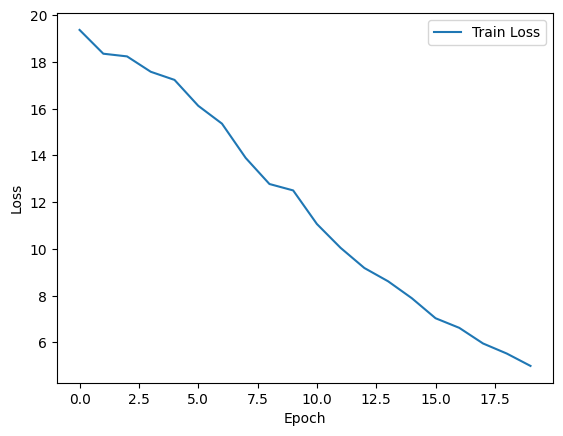

In [26]:
plt.plot(train_losses,label='Train Loss')
#plt.plot(test_losses,label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
torch.save(model.state_dict(), 'Model/Resnet_2.pt')

In [10]:
from local_param import Move
model.load_state_dict(torch.load('Model/Resnet_2.pt'))

/tmp/ipykernel_1056998/874406932.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Model/Resnet_2.pt'))


<All keys matched successfully>

In [15]:
from tqdm import tqdm
Test_frame=100
new_midline=np.zeros_like(midline[:Test_frame])
new_Observed_index=np.zeros_like(Observed_index[:Test_frame-1])
new_Observed_distance=np.zeros_like(Observed_distance[:Test_frame-1])
new_Observed_phi=np.zeros_like(Observed_phi[:Test_frame-1])
new_Observed_head_phi=np.zeros_like(Observed_head_phi[:Test_frame-1])
new_L1=np.zeros_like(L1[:Test_frame-1])
new_L2=np.zeros_like(L2[:Test_frame-1])
new_theta=np.zeros_like(theta[:Test_frame-1])
new_Radius=np.zeros_like(Radius[:Test_frame-1])
new_global_head_phi=np.zeros_like(global_head_phi[:Test_frame-1])
NUM_FISH=2
new_midline[0]=midline[0]
print(new_Observed_index.shape)
Predict_output=np.zeros((Test_frame, 2, 6))
with torch.no_grad():
    for i in tqdm(range(Test_frame-1)):
        new_head                =new_midline[i,:,0,:]-new_midline[i,:,1,:]
        new_tail                =new_midline[i,:,2,:]-new_midline[i,:,1,:]
        new_position            =new_midline[i,:,1,:]-DATA_circle[None,:2]
        new_global_head_phi[i]  =angle_between_2vec(new_head,-new_position, axis=1)
        new_theta[i]            =angle_between_2vec(-new_head, new_tail, axis=1)
        new_L1[i]               =np.linalg.norm(new_head, axis=1)
        new_L2[i]               =np.linalg.norm(new_tail, axis=1)
        new_Observed_vector     =new_midline[i,None,:,1,:]-new_midline[i,:,None,1,:]
        new_Observed_distance[i]=np.linalg.norm(new_Observed_vector, axis=2)
        new_Observed_phi[i]     =angle_between_2vec(new_head[:,None,:], new_Observed_vector, axis=2)
        new_Observed_head_phi[i]=angle_between_2vec(new_Observed_vector,new_head[None,:,:], axis=2)
        new_Observed_index[i]   =new_Observed_distance[i]<=R
        #new_Radius[i]=r-np.linalg.norm(new_position, axis=1)
        #new_Radius[i,new_Radius[i]>R]=-1
        new_Radius[i]=-1
        input_data              = np.zeros((NUM_FISH,4,grid,grid))
        for fish_id in range(NUM_FISH):
            input_data[fish_id] = DiscreteImage(Observed_index=new_Observed_index[i,fish_id],Observed_distance=new_Observed_distance[i,fish_id],Observed_phi=new_Observed_phi[i,fish_id],L1=new_L1[i],L2=new_L2[i],theta=new_theta[i],Radius=new_Radius[i,fish_id],global_head_phi=new_global_head_phi[i,fish_id],Observed_head_phi=new_Observed_head_phi[i,fish_id])
        input_data = torch.tensor(input_data, dtype=torch.float32).to('cuda')
        Predict_output[i] = model(input_data).detach().cpu().numpy()
        new_midline[i+1]=Move(new_midline[i],Predict_output[i,:,0],Predict_output[i,:,1],Predict_output[i,:,2], Predict_output[i,:,3:])

(99, 2, 2)


100%|██████████| 99/99 [00:00<00:00, 145.06it/s]


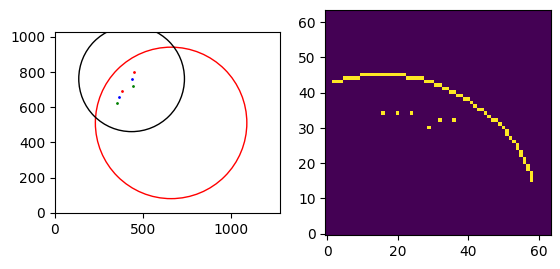

In [14]:
Observer_index=1
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2)
t_start=0
def animate(i):
    ax1.clear()
    ax2.clear()
    i+=t_start
    ax1.set_xlim(0, vid.shape[1])
    ax1.set_ylim(0, vid.shape[0])
    ax1.set_aspect('equal', adjustable='box')
    circle = plt.Circle((x,y), r, color='red', fill=False)
    ax1.add_patch(circle)
    ax1.plot(new_midline[i,:,0,0], new_midline[i,:,0,1], 'o', color='red', markersize=1)
    ax1.plot(new_midline[i,:,1,0], new_midline[i,:,1,1], 'o', color='blue', markersize=1)
    ax1.plot(new_midline[i,:,2,0], new_midline[i,:,2,1], 'o', color='green', markersize=1)
    circle = plt.Circle((new_midline[i,Observer_index,1,0], new_midline[i,Observer_index,1,1]), R, color='black', fill=False)
    ax1.add_patch(circle)
    Image=DiscreteImage(Observed_index=new_Observed_index[i,Observer_index],Observed_distance=new_Observed_distance[i,Observer_index],Observed_phi=new_Observed_phi[i,Observer_index],L1=new_L1[i],L2=new_L2[i],theta=new_theta[i],Radius=new_Radius[i,Observer_index],global_head_phi=new_global_head_phi[i,Observer_index],Observed_head_phi=new_Observed_head_phi[i,Observer_index])
    ax2.imshow(np.sum(Image, axis=0))
    ax2.invert_yaxis()
ani = FuncAnimation(fig, animate, frames=Test_frame-1, repeat=False)
# Show the animation as html
from IPython.display import HTML
HTML(ani.to_jshtml())


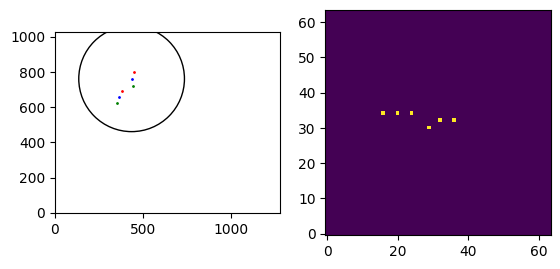

In [16]:
Observer_index=1
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2)
t_start=0
def animate(i):
    ax1.clear()
    ax2.clear()
    i+=t_start
    ax1.set_xlim(0, vid.shape[1])
    ax1.set_ylim(0, vid.shape[0])
    ax1.set_aspect('equal', adjustable='box')
    ax1.plot(new_midline[i,:,0,0], new_midline[i,:,0,1], 'o', color='red', markersize=1)
    ax1.plot(new_midline[i,:,1,0], new_midline[i,:,1,1], 'o', color='blue', markersize=1)
    ax1.plot(new_midline[i,:,2,0], new_midline[i,:,2,1], 'o', color='green', markersize=1)
    circle = plt.Circle((new_midline[i,Observer_index,1,0], new_midline[i,Observer_index,1,1]), R, color='black', fill=False)
    ax1.add_patch(circle)
    Image=DiscreteImage(Observed_index=new_Observed_index[i,Observer_index],Observed_distance=new_Observed_distance[i,Observer_index],Observed_phi=new_Observed_phi[i,Observer_index],L1=new_L1[i],L2=new_L2[i],theta=new_theta[i],Radius=new_Radius[i,Observer_index],global_head_phi=new_global_head_phi[i,Observer_index],Observed_head_phi=new_Observed_head_phi[i,Observer_index])
    ax2.imshow(np.sum(Image, axis=0))
    ax2.invert_yaxis()
ani = FuncAnimation(fig, animate, frames=Test_frame-1, repeat=False)
# Show the animation as html
from IPython.display import HTML
HTML(ani.to_jshtml())


In [17]:
ani.save("animation/2_no_wall.mp4", writer="ffmpeg")

(2,)


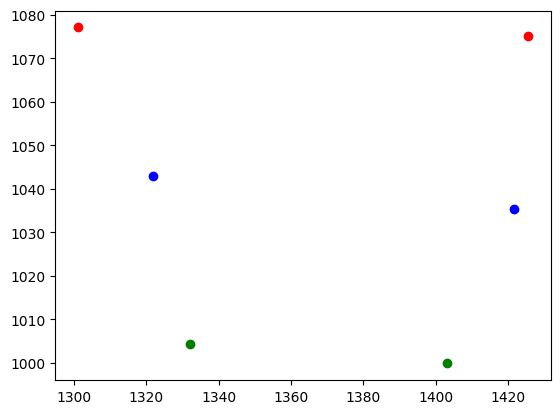

In [29]:
body1=np.random.randint(low=vid.shape[1]//2, high=3*vid.shape[1]//2,size=2)
initialtheta=2*np.pi*np.random.rand(2)
initialphi=np.pi/6*np.random.rand(2)
initialalpha=2*np.pi*np.random.rand()
head1=40*np.array([np.cos(initialtheta[0]),np.sin(initialtheta[0])])+body1
tail1=40*np.array([np.cos(initialtheta[0]+np.pi-initialphi[0]),np.sin(initialtheta[0]+np.pi-initialphi[0])])+body1
body2=100*np.array([np.cos(initialalpha),np.sin(initialalpha)])+body1
head2=40*np.array([np.cos(initialtheta[1]),np.sin(initialtheta[1])])+body2
tail2=40*np.array([np.cos(initialtheta[1]+np.pi-initialphi[1]),np.sin(initialtheta[1]+np.pi-initialphi[1])])+body2
rand_midline=np.zeros((2,3,2))
print(np.array([np.cos(initialalpha),np.sin(initialalpha)]).shape)
rand_midline[0]=np.array([head1,body1,tail1])
rand_midline[1]=np.array([head2,body2,tail2])
plt.scatter(rand_midline[:,0,0], rand_midline[:,0,1], color='red')
plt.scatter(rand_midline[:,1,0], rand_midline[:,1,1], color='blue')
plt.scatter(rand_midline[:,2,0], rand_midline[:,2,1], color='green')

In [30]:
from tqdm import tqdm
Test_frame=100
new_midline=np.zeros_like(midline[:Test_frame])
new_Observed_index=np.zeros_like(Observed_index[:Test_frame-1])
new_Observed_distance=np.zeros_like(Observed_distance[:Test_frame-1])
new_Observed_phi=np.zeros_like(Observed_phi[:Test_frame-1])
new_Observed_head_phi=np.zeros_like(Observed_head_phi[:Test_frame-1])
new_L1=np.zeros_like(L1[:Test_frame-1])
new_L2=np.zeros_like(L2[:Test_frame-1])
new_theta=np.zeros_like(theta[:Test_frame-1])
new_Radius=np.zeros_like(Radius[:Test_frame-1])
new_global_head_phi=np.zeros_like(global_head_phi[:Test_frame-1])
NUM_FISH=2
new_midline[0]=rand_midline
print(new_Observed_index.shape)
Predict_output=np.zeros((Test_frame, 2, 6))
with torch.no_grad():
    for i in tqdm(range(Test_frame-1)):
        new_head                =new_midline[i,:,0,:]-new_midline[i,:,1,:]
        new_tail                =new_midline[i,:,2,:]-new_midline[i,:,1,:]
        new_position            =new_midline[i,:,1,:]-DATA_circle[None,:2]
        new_global_head_phi[i]  =angle_between_2vec(new_head,-new_position, axis=1)
        new_theta[i]            =angle_between_2vec(-new_head, new_tail, axis=1)
        new_L1[i]               =np.linalg.norm(new_head, axis=1)
        new_L2[i]               =np.linalg.norm(new_tail, axis=1)
        new_Observed_vector     =new_midline[i,None,:,1,:]-new_midline[i,:,None,1,:]
        new_Observed_distance[i]=np.linalg.norm(new_Observed_vector, axis=2)
        new_Observed_phi[i]     =angle_between_2vec(new_head[:,None,:], new_Observed_vector, axis=2)
        new_Observed_head_phi[i]=angle_between_2vec(new_Observed_vector,new_head[None,:,:], axis=2)
        new_Observed_index[i]   =new_Observed_distance[i]<=R
        #new_Radius[i]=r-np.linalg.norm(new_position, axis=1)
        #new_Radius[i,new_Radius[i]>R]=-1
        new_Radius[i]=-1
        input_data              = np.zeros((NUM_FISH,4,grid,grid))
        for fish_id in range(NUM_FISH):
            input_data[fish_id] = DiscreteImage(Observed_index=new_Observed_index[i,fish_id],Observed_distance=new_Observed_distance[i,fish_id],Observed_phi=new_Observed_phi[i,fish_id],L1=new_L1[i],L2=new_L2[i],theta=new_theta[i],Radius=new_Radius[i,fish_id],global_head_phi=new_global_head_phi[i,fish_id],Observed_head_phi=new_Observed_head_phi[i,fish_id])
        input_data = torch.tensor(input_data, dtype=torch.float32).to('cuda')
        Predict_output[i] = model(input_data).detach().cpu().numpy()
        new_midline[i+1]=Move(new_midline[i],Predict_output[i,:,0],Predict_output[i,:,1],Predict_output[i,:,2], Predict_output[i,:,3:])

(99, 2, 2)


100%|██████████| 99/99 [00:00<00:00, 160.56it/s]


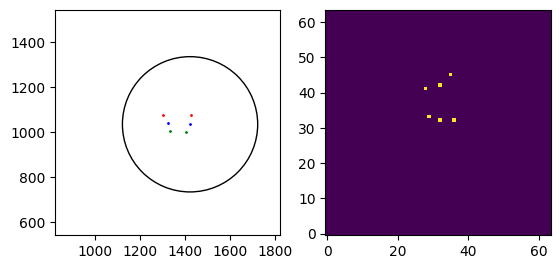

In [33]:
Observer_index=1
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2)
t_start=0
def animate(i):
    ax1.clear()
    ax2.clear()
    i+=t_start
    ax1.set_xlim(body1[0]-500, body1[0]+500)
    ax1.set_ylim(body1[1]-500, body1[1]+500)
    ax1.set_aspect('equal', adjustable='box')
    ax1.plot(new_midline[i,:,0,0], new_midline[i,:,0,1], 'o', color='red', markersize=1)
    ax1.plot(new_midline[i,:,1,0], new_midline[i,:,1,1], 'o', color='blue', markersize=1)
    ax1.plot(new_midline[i,:,2,0], new_midline[i,:,2,1], 'o', color='green', markersize=1)
    circle = plt.Circle((new_midline[i,Observer_index,1,0], new_midline[i,Observer_index,1,1]), R, color='black', fill=False)
    ax1.add_patch(circle)
    Image=DiscreteImage(Observed_index=new_Observed_index[i,Observer_index],Observed_distance=new_Observed_distance[i,Observer_index],Observed_phi=new_Observed_phi[i,Observer_index],L1=new_L1[i],L2=new_L2[i],theta=new_theta[i],Radius=new_Radius[i,Observer_index],global_head_phi=new_global_head_phi[i,Observer_index],Observed_head_phi=new_Observed_head_phi[i,Observer_index])
    ax2.imshow(np.sum(Image, axis=0))
    ax2.invert_yaxis()
ani = FuncAnimation(fig, animate, frames=Test_frame-1, repeat=False)
# Show the animation as html
from IPython.display import HTML
HTML(ani.to_jshtml())
